In [1]:
%matplotlib inline
from prophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = 9, 6

As a result of the lockdowns caused by the COVID-19 pandemic, many time series experienced "shocks" during 2020, e.g. spikes in media consumption (Netflix, YouTube), e-commerce transactions (Amazon, eBay), whilst attendance to in-person events declined dramatically.

Most of these time series would also maintain their new level for a period of time, subject to fluctuations driven by easing of lockdowns and/or vaccines.

Seasonal patterns could have also changed: for example, people may have consumed less media (in total hours) on weekdays compared to weekends before the COVID lockdowns, but during lockdowns weekday consumption could be much closer to weekend consumption.

In this page we'll explore some strategies for capturing these effects using Prophet's functionality:

1. Marking step changes / spikes due to COVID events as once-off.
2. Sustained changes in behaviour leading to trend and seasonality changes.

#### Case Study - Pedestrian Activity

For this case study we'll use [Pedestrian Sensor data from the City of Melbourne](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp). This data measures foot traffic from sensors in various places in the central business district, and we've chosen one sensor (`Sensor_ID = 4`) and aggregated the values to a daily grain. 

The aggregated dataset can be found in the examples folder [here](https://github.com/facebook/prophet/tree/master/examples/example_pedestrians_covid.csv).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv')

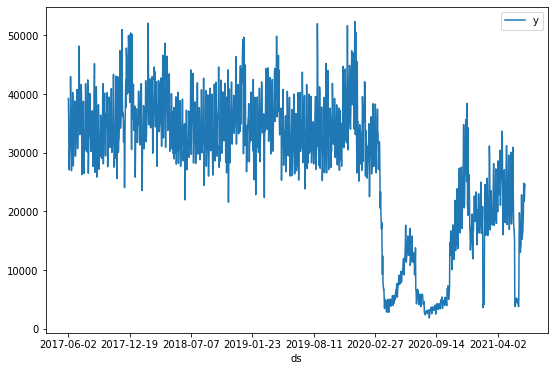

In [3]:
df.set_index('ds').plot();

We can see two key events in the time series:

* The initial drop in foot traffic around 21 March 2020, which started to recover around 6 June 2020. This corresponds to the declaration of a pandemic by WHO and subsequent lockdowns mandated by the Victorian government.
* After some slow recovery, a second drop in foot traffic around July 9 2020, which began to recover around 27 October 2020. This corresponds to the "second wave" of the pandemic in metropolitan Melbourne.

There are also shorter periods of strict lockdown that lead to sudden tips in the time series: 5 days in February 2021, and 14 days in early June 2021.

#### Default model without any adjustments

First we'll fit a model with the default Prophet settings:

In [4]:
m = Prophet()
m = m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

02:53:41 - cmdstanpy - INFO - Chain [1] start processing
02:53:41 - cmdstanpy - INFO - Chain [1] done processing


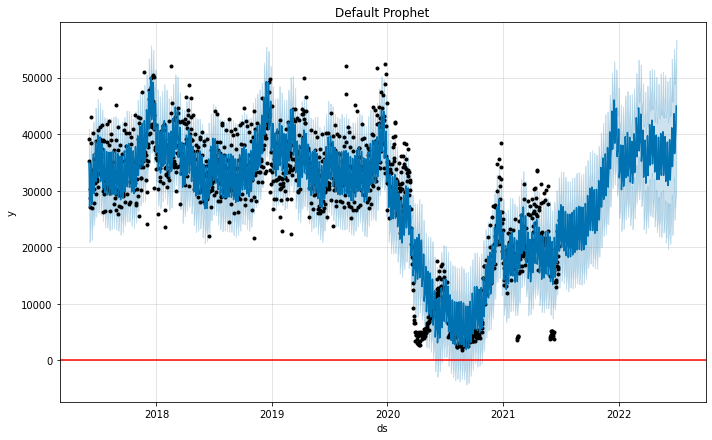

In [5]:
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Default Prophet');

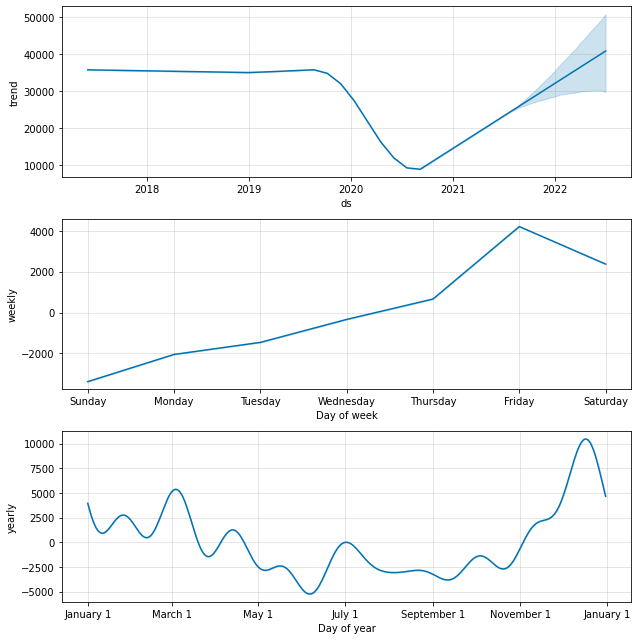

In [6]:
m.plot_components(forecast);

The model seems to fit reasonably to past data, but notice how we're capturing the dips, and the spikes after the dips, as a part of the trend component. 

By default, the model assumes that these large spikes are possible in the future, even though we realistically won't see something of the same magnitude within our forecast horizon (1 year in this case). This leads to a fairly optimistic forecast of the recovery of foot traffic in 2022.

### Treating COVID-19 lockdowns as a one-off holidays

To prevent large dips and spikes from being captured by the trend component, we can treat the days impacted by COVID-19 as holidays that will not repeat again in the future. Adding custom holidays is explained in more detail [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events). We set up a DataFrame like so to describe the periods affected by lockdowns:

In [7]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


* We have an entry for each lockdown period, with `ds` specifying the start of the lockdown. `ds_upper` is not used by Prophet, but it's a convenient way for us to calculate `upper_window`.
* `upper_window` tells Prophet that the lockdown spans for x days after the start of the lockdown. Note that the holidays regression is inclusive of the upper bound.

Note that since we don't specify any future dates, Prophet will assume that these holidays will _not_ occur again when creating the future dataframe (and hence they won't affect our projections). This is different to how we would specify a recurring holiday.

In [8]:
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

02:53:44 - cmdstanpy - INFO - Chain [1] start processing
02:53:45 - cmdstanpy - INFO - Chain [1] done processing


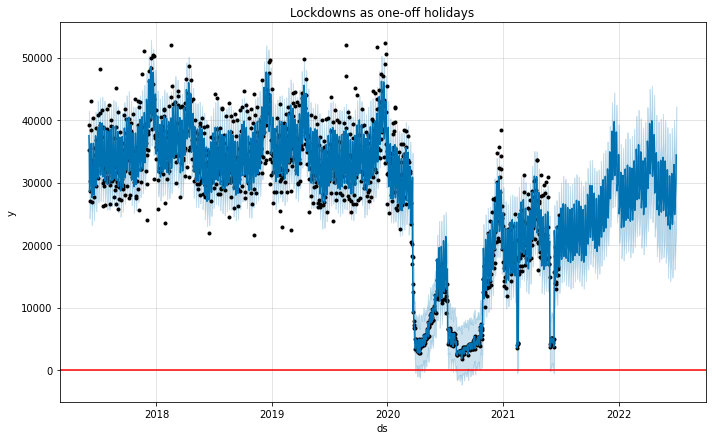

In [9]:
m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');

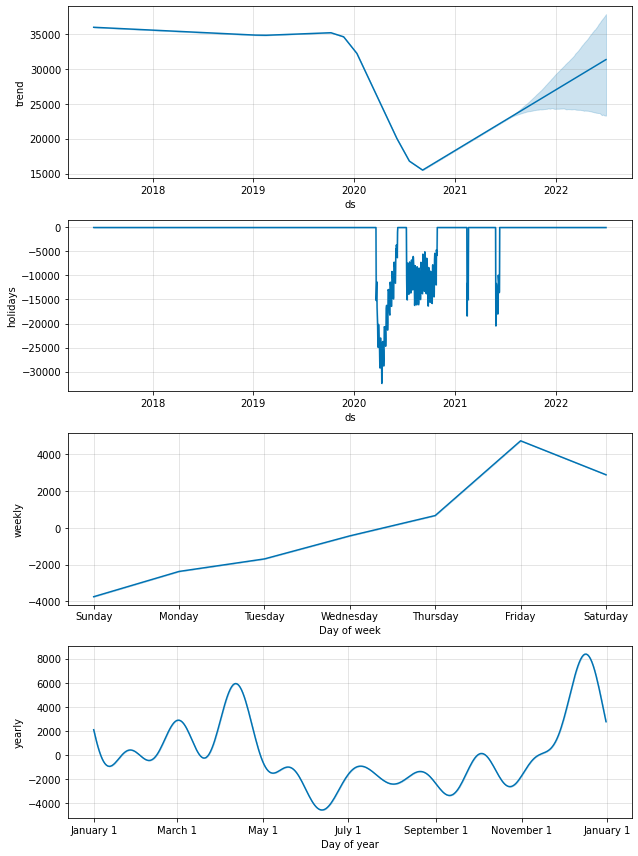

In [10]:
m2.plot_components(forecast2);

* Prophet is sensibly assigning a large negative effect to the days within the lockdown periods.
* The forecast for the trend is not as strong / optimistic and seems fairly reasonable.

### Sense checking the trend

In an environment when behaviours are constantly changing, it's important to ensure that the trend component of the model is capturing to emerging patterns without overfitting to them.

The [trend changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html) documentation explains two things we could tweak with the trend component:

* The changepoint locations, which by default are evenly spaced across 80% of the history. We should be mindful of where this range ends, and extend the range (either by increasing the % or adding changepoints manually) if we believe the most recent data better reflects future behaviour.
* The strength of regularisation (`changepoint_prior_scale`), which determines how flexible the trend is; the default value is `0.05` and increasing this will allow the trend to fit more closely to the observed data.

We plot the trend component and changepoints detected by our current model below.

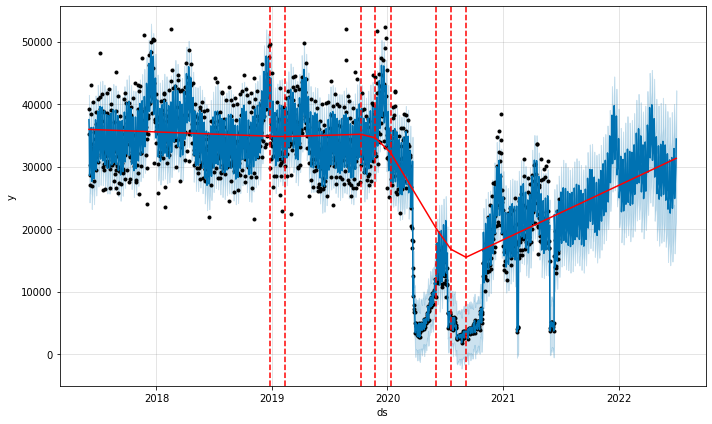

In [11]:
from prophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)

The detected changepoints look reasonable, and the future trend tracks the latest upwards trend in activity, but not to the extent of late 2020. This seems suitable for a best guess of future activity. 

We can see what the forecast would look like if we wanted to emphasize COVID patterns more in model training; we can do this by adding more potential changepoints after 2020 and making the trend more flexible.

In [12]:
m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range('2017-06-02', '2020-01-01', periods=10).date.tolist() + 
    # 15 potential changepoints in 1 year 2 months
    pd.date_range('2020-02-01', '2021-04-01', periods=15).date.tolist()
)

In [13]:
# Default changepoint_prior_scale is 0.05, so 1.0 will lead to much more flexibility in comparison.
m3 = Prophet(holidays=lockdowns, changepoints=m3_changepoints, changepoint_prior_scale=1.0)
m3 = m3.fit(df)
forecast3 = m3.predict(future2)

02:53:49 - cmdstanpy - INFO - Chain [1] start processing
02:53:52 - cmdstanpy - INFO - Chain [1] done processing


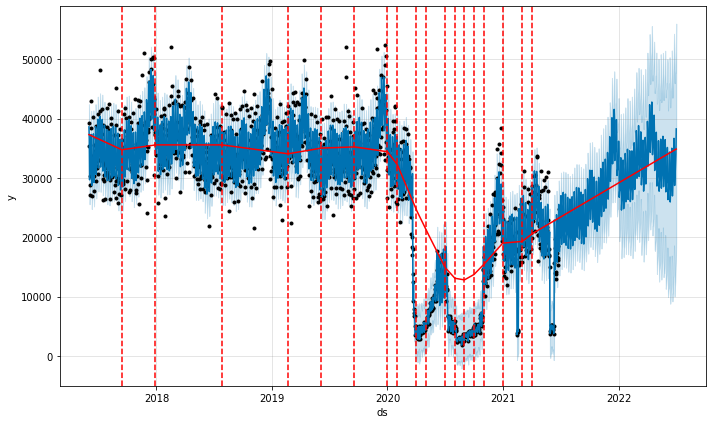

In [14]:
from prophet.plot import add_changepoints_to_plot
fig = m3.plot(forecast3)
a = add_changepoints_to_plot(fig.gca(), m3, forecast3)

We're seeing many changepoints detected post-COVID, matching the various fluctuations from loosening / tightening lockdowns. Overall the trend curve and forecasted trend are quite similar to our previous model, but we're seeing a lot more uncertainty because of the higher number of trend changes we picked up in the history.

We probably wouldn't pick this model over the model with default parameters as a best estimate, but it's a good demonstration of how we can incorporate our beliefs into the model about which patterns are important to capture.

### Changes in seasonality between pre- and post-COVID

The seasonal component plots in the previous sections show a peak of activity on Friday compared to other days of the week. If we're not sure whether this will still hold post-lockdown, we can add _conditional seasonalities_ to the model. Conditional seasonalities are explained in more detail [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#seasonalities-that-depend-on-other-factors).

First we define boolean columns in the history dataframe to flag "pre covid" and "post covid" periods:

In [15]:
df2 = df.copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-21')
df2['post_covid'] = ~df2['pre_covid']

The conditional seasonality we're interested in modelling here is the day-of-week ("weekly") seasonality. To do this, we firstly turn off the default `weekly_seasonality` when we create the Prophet model.

In [16]:
m4 = Prophet(holidays=lockdowns, weekly_seasonality=False)

We then add this weekly seasonality manually, as two different model components - one for pre-covid, one for post-covid. Note that `fourier_order=3` is the default setting for weekly seasonality. After this we can run `.fit()`.

In [17]:
m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
);

In [18]:
m4 = m4.fit(df2)

02:53:55 - cmdstanpy - INFO - Chain [1] start processing
02:53:56 - cmdstanpy - INFO - Chain [1] done processing


We also need to create the `pre_covid` and `post_covid` flags in the future dataframe. This is so that Prophet can apply the correct weekly seasonality parameters to each future date.

In [19]:
future4 = m4.make_future_dataframe(periods=366)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < pd.to_datetime('2020-03-21')
future4['post_covid'] = ~future4['pre_covid']

In [20]:
forecast4 = m4.predict(future4)

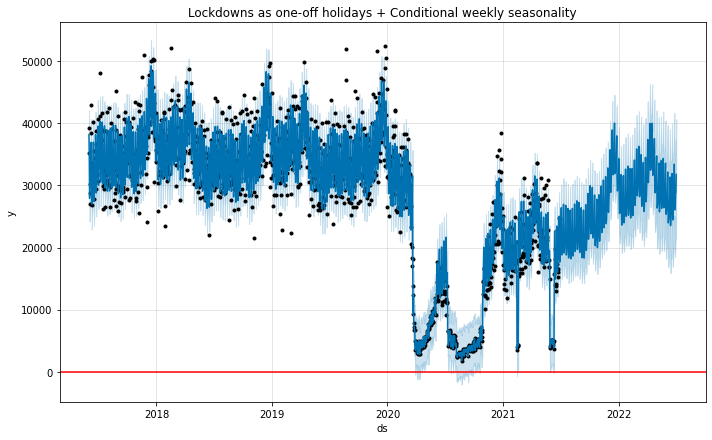

In [21]:
m4.plot(forecast4)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality');

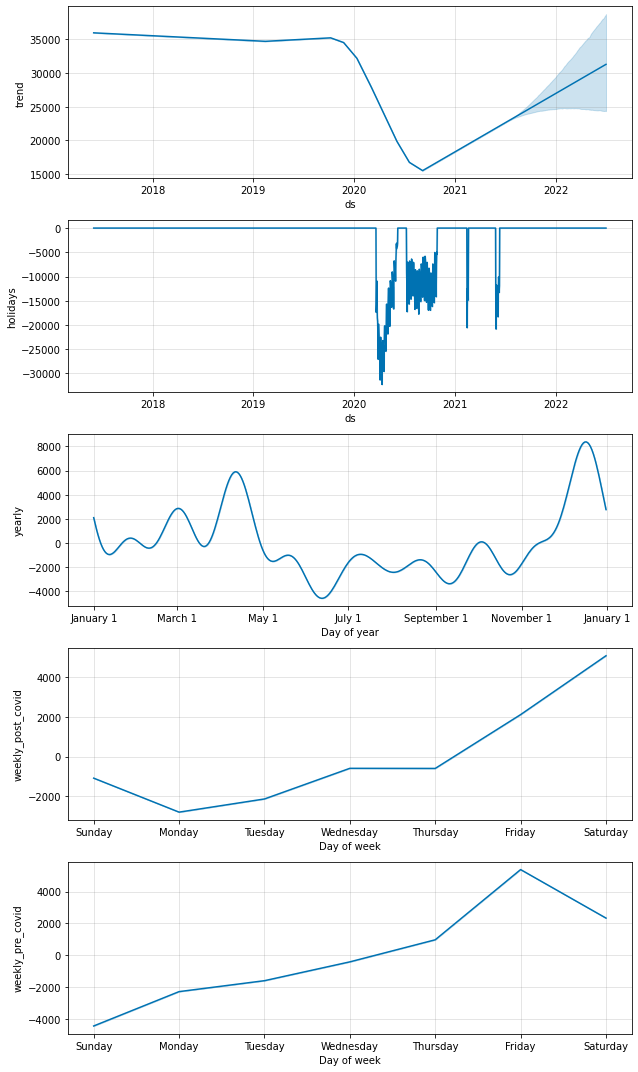

In [22]:
m4.plot_components(forecast4);

Interestingly, the model with conditional seasonalities suggests that, post-COVID, pedestrian activity peaks on Saturdays, instead of Fridays. This could make sense if most people are still working from home and are hence less likely to go out on Friday nights. From a prediction perspective this would only be important if we care about predicting weekdays vs. weekends accurately, but overall this kind of exploration helps us gain insight into how COVID has changed behaviours.

#### Further reading

A lot of the content in this page was inspired by this [GitHub discussion](https://github.com/facebook/prophet/issues/1416). We've covered a few low hanging fruits for tweaking Prophet models when faced with shocks such as COVID, but there are many other possible approaches as well, such as:

* Using external regressors (e.g. the lockdown stringency index). This would only be fruitful if we a) have regressor data that aligns well (in terms of location) with the series we're forecasting, and b) have control over or can predict the regressor much more accurately than the time series alone.
* Detecting and removing outlier data from the training period, or throwing away older training data completely. This might be a better approach for sub-daily time series that don't have yearly seasonal patterns.

Overall though it's difficult to be confident in our forecasts in these environments when rules are constantly changing and outbreaks occur randomly. In this scenario it's more important to constantly re-train / re-evaluate our models and clearly communicate the increased uncertainty in forecasts.